# Data Loading and Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dython import nominal
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import RFE
import pickle

In [2]:
data_dir = './data/'

In [3]:
results_dir = './data/results/'

In [4]:
models_dir = './models/'

In [5]:
model_name = 'linear_regression'

In [6]:
regression_data = pd.read_csv(data_dir+'regression_data.csv', index_col=[0])

# Linear Regression (Regression)

Sort the dataset so we can drop the date column

In [7]:
regression_data = regression_data.sort_values(by=['date', 'team', 'department']).reset_index(drop=True)

In [8]:
dep_var = ['targeted_productivity']

In [9]:
regression_data

,date,department,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,...,targeted_productivity_rmean_1_1,targeted_productivity_rmean_2_1,targeted_productivity_rmean_1_2,targeted_productivity_rmean_2_2,actual_productivity_lag_2,actual_productivity_lag_4,actual_productivity_rmean_2_1,actual_productivity_rmean_4_1,actual_productivity_rmean_2_2,actual_productivity_rmean_4_2
0,2015-01-01,finishing,1,0.75,3.94,0.0,960,0,0.0,0,...,0.00,0.00,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,2015-01-01,sweing,1,0.75,28.08,681.0,6900,45,0.0,0,...,0.75,0.00,0.375,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,2015-01-01,finishing,2,0.75,3.94,0.0,960,0,0.0,0,...,0.00,0.00,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,2015-01-01,sweing,2,0.75,19.88,733.0,6000,34,0.0,0,...,0.75,0.00,0.375,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,2015-01-01,sweing,3,0.75,28.08,795.0,6900,45,0.0,0,...,0.00,0.00,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,2015-03-11,sweing,10,0.75,21.81,1674.0,6000,34,0.0,0,...,0.70,0.75,0.725,0.725,0.7505,0.7000,0.7505,0.7000,0.6140,0.5710
1193,2015-03-11,finishing,11,0.80,2.90,0.0,2400,0,0.0,0,...,0.80,0.80,0.800,0.800,0.8000,0.9604,0.8000,0.9604,0.8000,0.8580
1194,2015-03-11,sweing,11,0.80,11.41,560.0,3420,50,0.0,0,...,0.80,0.80,0.800,0.800,0.7583,0.8000,0.7583,0.8000,0.7793,0.8800
1195,2015-03-11,finishing,12,0.80,4.60,0.0,2160,0,0.0,0,...,0.80,0.80,0.800,0.800,0.9200,0.9030,0.9200,0.9030,0.8604,0.8516


In [10]:
categorical = np.array(['department', 'team'])

In [11]:
continuous = np.setdiff1d(np.setdiff1d(regression_data.columns,categorical), dep_var)

In [12]:
continuous = continuous[continuous != 'date']

In [13]:
X = regression_data.loc[:,np.union1d(categorical, continuous)]

In [14]:
y = regression_data.loc[:,dep_var]*100

In [15]:
columns = ['task', 'model', 'split', 'number_of_features', 'valid_mean_value', 'predicted_mean_value', 'percentage_difference', 'valid_rsq', 'valid_mae', 'valid_mse', 'valid_rmse']
linear_regression_results_df = pd.DataFrame(columns=columns)
df_rows = 0

Now we need to prepare our data and the cross-validation process so that we can start training. As we are dealing with time-series we need to split the data appropriately. We will use 20% of the data for testing.

In [16]:
test_idx = int((0.2*len(X)))

In [17]:
X_train, X_test, y_train, y_test = X.iloc[:len(X)- test_idx, :], X.iloc[len(X)- test_idx:, :], y.iloc[:len(y)- test_idx, :], y.iloc[len(y)- test_idx:, :]

In [18]:
pd.options.mode.chained_assignment = None  # default='warn'
# Cross-Validation Pipeline
# assign the tuned parameters
split = 0
tscv = TimeSeriesSplit(n_splits=5)
for train_index, valid_index in tscv.split(X_train):
    # Data Split
    split += 1
    X_train_curr_split = X_train.iloc[train_index]
    X_valid_curr_split = X_train.iloc[valid_index]
    y_train_curr_split = y_train.iloc[train_index]
    y_valid_curr_split = y_train.iloc[valid_index]
    # Avoiding data leakage for input values
    # We need to encode only categorical variables
    enc = preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100)
    X_train_curr_split.loc[:, categorical] = enc.fit_transform(X_train_curr_split[categorical])
    X_valid_curr_split.loc[:, categorical] = enc.transform(X_valid_curr_split[categorical])
    
    y_train_curr_split = y_train_curr_split.values.flatten()
    y_valid_curr_split = y_valid_curr_split.values.flatten()
    for features in range(2, X_train_curr_split.shape[1]):
        rfe = RFE(estimator=LinearRegression(fit_intercept=True), n_features_to_select=features)
        pipe = make_pipeline(rfe,
                             preprocessing.StandardScaler(), 
                             LinearRegression(fit_intercept=True),
                            )
        # train the model
        pipe.fit(X_train_curr_split, y_train_curr_split)
        valid_predictions = pipe.predict(X_valid_curr_split)
        # Obtain metric scores
        valid_mae = mean_absolute_error(y_valid_curr_split, valid_predictions)
        valid_mse = mean_squared_error(y_valid_curr_split, valid_predictions)
        valid_rmse = mean_squared_error(y_valid_curr_split, valid_predictions, squared=False)
        valid_rsq = r2_score(y_valid_curr_split, valid_predictions)
        valid_mean_value = y_valid_curr_split.mean()
        predicted_mean_value = valid_predictions.mean()
        percetange_difference = ((y_valid_curr_split - valid_predictions)/(y_valid_curr_split)).mean()
        linear_regression_results_df.loc[df_rows] = ['regression',
                                                     'linear regression',
                                                     split,
                                                     features,
                                                     valid_mean_value,
                                                     predicted_mean_value,
                                                     percetange_difference,
                                                     valid_rsq,
                                                     valid_mae,
                                                     valid_mse,
                                                     valid_rmse
                                                    ]
        # increment the rows variable
        df_rows +=1

In [19]:
pd.options.mode.chained_assignment = 'warn'

## Functions

In [20]:
def group_seeded_data(data, groupby_columns, droped_cols=['seed', 'split']):
    grouped_data = data.groupby(groupby_columns).agg('mean').reset_index().drop(droped_cols, axis=1)
    return grouped_data

In [21]:
linear_regression_results_df

,task,model,split,number_of_features,valid_mean_value,predicted_mean_value,percentage_difference,valid_rsq,valid_mae,valid_mse,valid_rmse
0,regression,linear regression,1,2,73.364780,77.312804,-0.096818,-0.072205,7.392356,149.197309,12.214635
1,regression,linear regression,1,3,73.364780,77.382660,-0.097746,-0.078326,7.423663,150.048956,12.249447
2,regression,linear regression,1,4,73.364780,77.388603,-0.097811,-0.077659,7.415147,149.956147,12.245658
3,regression,linear regression,1,5,73.364780,77.355312,-0.097310,-0.074219,7.420968,149.477593,12.226103
4,regression,linear regression,1,6,73.364780,76.319495,-0.079571,0.029031,7.058758,135.110258,11.623694
...,...,...,...,...,...,...,...,...,...,...,...
115,regression,linear regression,5,21,73.144654,67.354555,0.067636,-0.954703,9.700300,131.883115,11.484037
116,regression,linear regression,5,22,73.144654,68.187132,0.055645,-0.704707,8.866142,115.015971,10.724550
117,regression,linear regression,5,23,73.144654,68.181857,0.055718,-0.704847,8.871535,115.025420,10.724990
118,regression,linear regression,5,24,73.144654,68.170303,0.055906,-0.702096,8.868972,114.839827,10.716335


In [19]:
linear_regression_results_df.to_csv(results_dir + 'linear_regression_results_df.csv')

Aggregate the values so that we average the results for each split

In [23]:
grouped_linear_regression_results_df = group_seeded_data(linear_regression_results_df, 
                                                         ['number_of_features'],
                                                         ['split']
                                                         )

In [24]:
grouped_linear_regression_results_df

,number_of_features,valid_mean_value,predicted_mean_value,percentage_difference,valid_rsq,valid_mae,valid_mse,valid_rmse
0,2,72.41761,74.659105,-0.070478,0.074526,6.178487,99.642719,9.876473
1,3,72.41761,74.687269,-0.070115,0.098934,6.014236,96.558137,9.719988
2,4,72.41761,74.702573,-0.069924,0.111109,5.899571,95.127047,9.642918
3,5,72.41761,74.668912,-0.069416,0.110058,5.915964,94.984329,9.639451
4,6,72.41761,74.084372,-0.057117,0.221471,5.620456,83.790710,9.040597
5,7,72.41761,73.975090,-0.055365,0.221076,5.627676,83.995032,9.044876
6,8,72.41761,73.538304,-0.047984,0.211821,5.783762,84.997245,9.098507
7,9,72.41761,73.478467,-0.046527,0.214727,5.859601,84.433934,9.079578
8,10,72.41761,73.463475,-0.046217,0.214615,5.864895,84.448303,9.080360
9,11,72.41761,71.651139,-0.020114,0.185374,6.153501,86.181487,9.191966


In [23]:
grouped_linear_regression_results_df.to_csv(results_dir + 'grouped_linear_regression_results_df.csv')

## Functions

In [42]:
def plot_line(data, x_column = 'number_of_features', title='Line graph', title_size=25, axes_size=15, tick_size=12, acc = 'valid_accuracy'):
    X = data[x_column].copy()
    y = data[acc].copy()
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(X, y)
    
    acc_label = acc.split('_')[0]
    fig.suptitle(title + f' for {acc} metric score for {x_column} combinations', fontsize=title_size,  y=1.02)
    ax.set_xlabel(f'{x_column}', fontsize=axes_size)
    ax.set_ylabel(f'{acc}'.capitalize(), fontsize=axes_size)
    ax.tick_params(axis='x', which='major', labelsize=tick_size)
    ax.tick_params(axis='y', which='major', labelsize=tick_size)
    plt.show()

In [50]:
def plot_difference(y_test, predictions_test, title='Scatter plot', title_size=25, axes_size=15, tick_size=12, acc = 'valid_accuracy'):
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.scatter(y_test, predictions_test)
    min_y = y_test.min()
    min_predictions = predictions_test.min()
    min_val = np.minimum(min_y, min_predictions)
    ax.axline((min_val, min_val), slope=1, color='black')   
    
    acc_label = acc.split('_')[0]
    fig.suptitle(title + f' for expected vs predicted output', fontsize=title_size,  y=1.02)
    ax.set_xlabel('Expected output', fontsize=axes_size)
    ax.set_ylabel('Predicted output', fontsize=axes_size)
    ax.tick_params(axis='x', which='major', labelsize=tick_size)
    ax.tick_params(axis='y', which='major', labelsize=tick_size)
    plt.show()

## Overal results demonstration

### Valid percentage difference for number of features

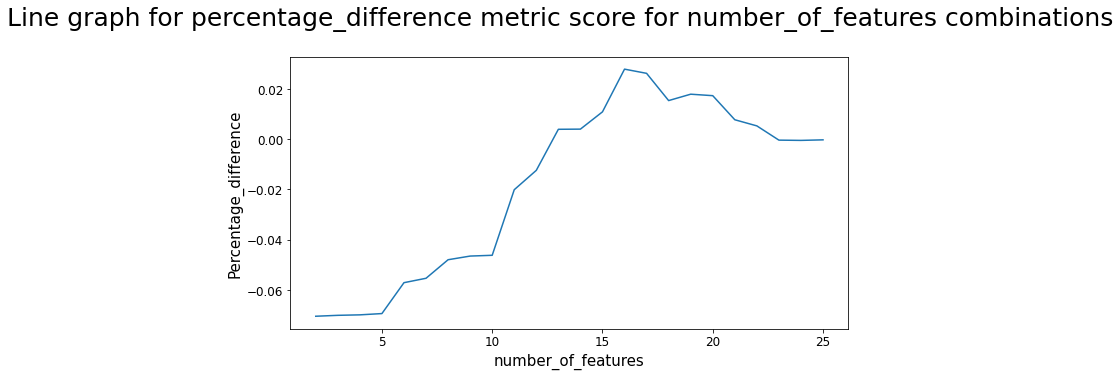

In [43]:
plot_line(grouped_linear_regression_results_df, acc='percentage_difference')

### Valid Rsq for number of features

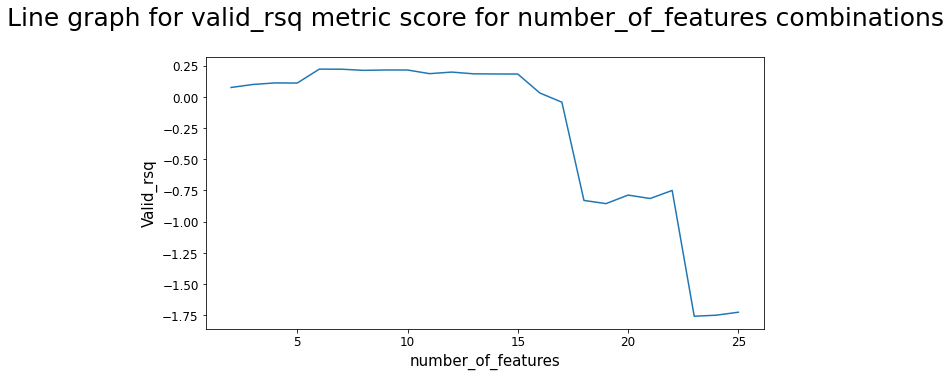

In [44]:
plot_line(grouped_linear_regression_results_df, acc='valid_rsq')

### Valid MAE for number of features

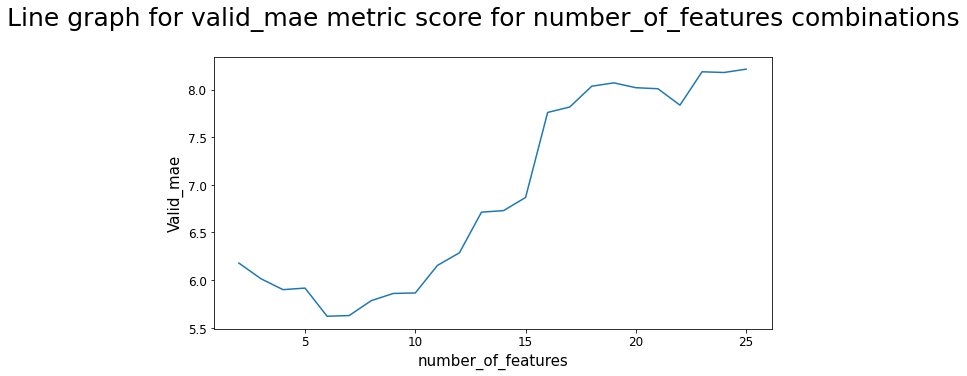

In [47]:
plot_line(grouped_linear_regression_results_df, acc='valid_mae')

### Valid MSE for number of features

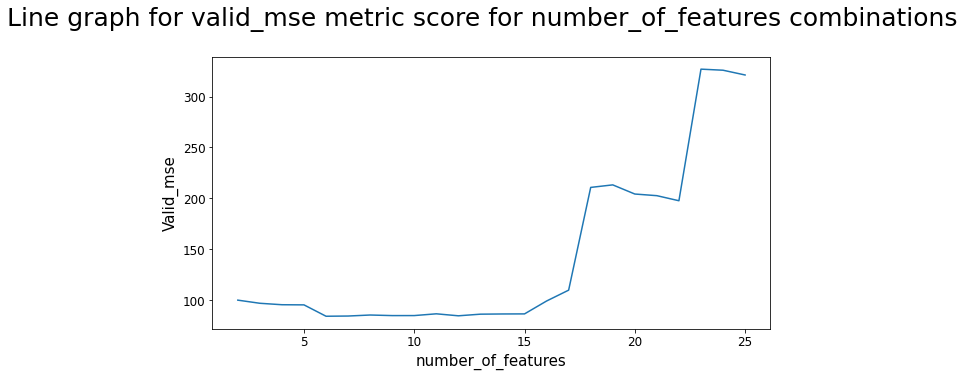

In [49]:
plot_line(grouped_linear_regression_results_df, acc='valid_mse')

### Valid RMSE for number of features

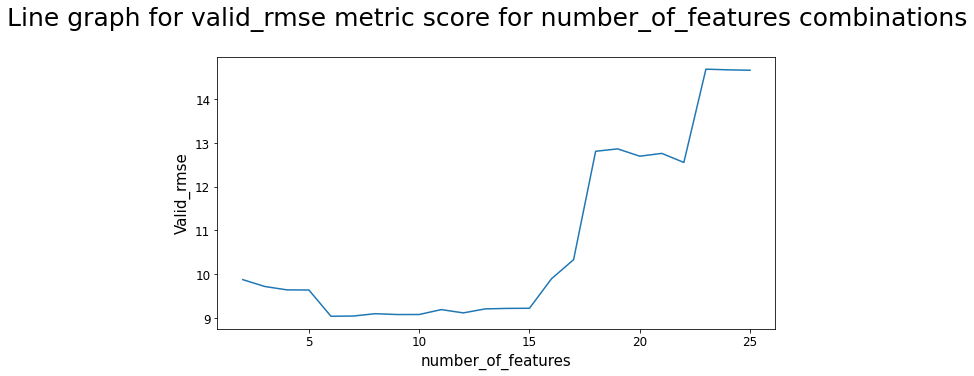

In [50]:
plot_line(grouped_linear_regression_results_df, acc='valid_rmse')

## Build best model

From the above line graphs it can be observed that MAE, MSE, RMSE (best when the value is close to 0) achieve their best results when the number of features is in between 5 and 10. Rsq metric (best when closeto 1) achieve its best score in similar region - 5 to 15. After a closer look in the dataset it is made clear that the best results are achieved when the number of features is 6.

In [56]:
grouped_linear_regression_results_df[grouped_linear_regression_results_df['valid_rmse'] == grouped_linear_regression_results_df['valid_rmse'].min()]

,number_of_features,percentage_difference,valid_rsq,valid_mae,valid_mse,valid_rmse
4,6,-0.057117,0.221471,5.620456,83.79071,9.040597


In [57]:
grouped_linear_regression_results_df[grouped_linear_regression_results_df['valid_mse'] == grouped_linear_regression_results_df['valid_mse'].min()]

,number_of_features,percentage_difference,valid_rsq,valid_mae,valid_mse,valid_rmse
4,6,-0.057117,0.221471,5.620456,83.79071,9.040597


In [58]:
grouped_linear_regression_results_df[grouped_linear_regression_results_df['valid_mae'] == grouped_linear_regression_results_df['valid_mae'].min()]

,number_of_features,percentage_difference,valid_rsq,valid_mae,valid_mse,valid_rmse
4,6,-0.057117,0.221471,5.620456,83.79071,9.040597


In [59]:
grouped_linear_regression_results_df[grouped_linear_regression_results_df['valid_rsq'] == grouped_linear_regression_results_df['valid_rsq'].max()]

,number_of_features,percentage_difference,valid_rsq,valid_mae,valid_mse,valid_rmse
4,6,-0.057117,0.221471,5.620456,83.79071,9.040597


Now we need to save the best model and test it on the test data.

In [60]:
rfe = RFE(estimator=LinearRegression(fit_intercept=True), n_features_to_select=6)

In [61]:
best_pipe = make_pipeline(rfe,
                     preprocessing.StandardScaler(), 
                     LinearRegression(fit_intercept=True),
                    )

Preprocess the data

In [62]:
enc = preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100)
X_train.loc[:, categorical] = enc.fit_transform(X_train[categorical])
X_test.loc[:, categorical] = enc.transform(X_test[categorical])

y_train_enc = y_train.values.flatten()
y_test_enc = y_test.values.flatten()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7268\2457187115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:, categorical] = enc.fit_transform(X_train[categorical])
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7268\2457187115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:, categorical] = enc.transform(X_test[categorical])


Fit the model

In [63]:
best_pipe.fit(X_train, y_train_enc)

Pipeline(steps=[('rfe',
                 RFE(estimator=LinearRegression(), n_features_to_select=6)),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

Obtain metric scores

In [64]:
test_predictions = best_pipe.predict(X_test)
test_mae = mean_absolute_error(y_test_enc, test_predictions)
test_mse = mean_squared_error(y_test_enc, test_predictions)
test_rmse = mean_squared_error(y_test_enc, test_predictions, squared=False)
test_rsq = r2_score(y_test_enc, test_predictions)

### Results on test set

In [65]:
print(f"The MAE score on the test set for the best model is {test_mae.round(3)} \n")

The MAE score on the test set for the best model is 4.27 



In [66]:
print(f"The MSE score on the test set for the best model is {test_mse.round(3)} \n")

The MSE score on the test set for the best model is 45.038 



In [67]:
print(f"The RMSE score on the test set for the best model is {test_rmse.round(3)} \n")

The RMSE score on the test set for the best model is 6.711 



In [68]:
print(f"The Rsq score on the test set for the best model is {test_rsq.round(3)} \n")

The Rsq score on the test set for the best model is 0.436 



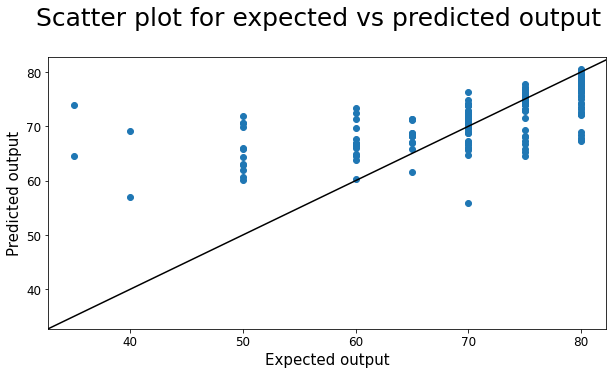

In [69]:
plot_difference(y_test_enc, test_predictions)

Save the model on disc

In [70]:
pickle.dump(best_pipe, open(models_dir+model_name, 'wb'))

Load the model from disk

In [71]:
loaded_best_pipe = pickle.load(open(models_dir+model_name, 'rb'))